## **Technical cells**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install --upgrade torch
!pip install --upgrade wandb
!pip install --upgrade catalyst
!pip install --upgrade torchtext
!pip install --upgrade nlpaug
!wandb login c54b2fcb6b8ca2808f5be303a8a3b6e464f52cca

     |████████████████████████████████| 752.0MB 23kB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.5.0 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
     |████████████████████████████████| 1.4MB 3.4MB/s 
     |████████████████████████████████| 102kB 15.2MB/s 
     |████████████████████████████████| 460kB 53.3MB/s 
     |████████████████████████████████| 102kB 15.8MB/s 
     |████████████████████████████████| 112kB 73.4MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 71kB 12.0MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.2-cp36-none-any.whl size=73605 sha256=629626bfe9ad36605cfc9e58a190a0e9124b3853ece06be6b7ebee5ef43518d9
  Stored in directory: /root/.cache/pip/wheels/bc/ed/6c/028dea90d31b359cd2a7c8b0da4db80e41d24a59614154072e
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-non

In [3]:
import torch
import torchtext
import nlpaug
import wandb
import catalyst
print("Torchtext Version:", torchtext.__version__)
print("PyTorch Version:", torch.__version__)
print("Catalyst Version:", catalyst.__version__)
print("Wandb Version:", wandb.__version__)
print("NLP-AUG Version:", nlpaug.__version__)

Torchtext Version: 0.6.0
PyTorch Version: 1.5.0
Catalyst Version: 20.04.2
Wandb Version: 0.8.32
NLP-AUG Version: 0.0.13.3


In [0]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [0]:
def get_device():
	if torch.cuda.is_available():
		return torch.device('cuda:0')
	else:
		return torch.device('cpu')

device = get_device()


## **Introducing cells**

In [6]:
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchtext import data
from torchtext import datasets
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from catalyst import dl
import wandb
import sklearn.datasets
import re
import copy
import time

DEVICE = 'cuda'
COURSEWORK_PATH = 'drive/My Drive/text-augmentation/'
AUGMENTED_DATA_PATH = COURSEWORK_PATH + 'aug_data/'

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [7]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# **Different NLPAUG Methods**

In [0]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nlpaug.model.word_stats as nmw

from nlpaug.util import Action

## **Pre-training of NLPAUG TfIdfAugmenter:**



In [0]:
def _tokenizer(text, token_pattern=r"(?u)\b\w\w+\b"):
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(text)

In [10]:
%%time

train_tfidf_data = sklearn.datasets.fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
train_x = train_tfidf_data.data

# apply tokenizing to the inputs
train_x_tokens = [_tokenizer(x) for x in train_x]

# Train TF-IDF model
tfidf_model = nmw.TfIdf()
tfidf_model.train(train_x_tokens)
tfidf_model.save(COURSEWORK_PATH)

CPU times: user 7.9 s, sys: 1.89 s, total: 9.79 s
Wall time: 12.8 s


## **Possible actions for NLPAUG**

Any transformation with a text.

In [11]:
actions = Action.getall()

for i, action in enumerate(actions):
    print(f"{i}-th transformation: {action}")

0-th transformation: insert
1-th transformation: substitute
2-th transformation: swap
3-th transformation: delete
4-th transformation: split
5-th transformation: sequential
6-th transformation: sometimes


In [12]:
# add default choice for the augmenters without possible actions
actions.append("default")
print(len(actions))

8


**However**, some of the actions are not implemented for some augmenters. Let's map augmenter name to its possible actions. <br>

Action **full** means the union of other possible actions.

In [0]:
augmenter_names = ["random", "tf-idf", "synonym", "compose"]
possible_actions = {
    "random": ['insert', 'substitute', 'swap', 'delete', 'full'],
    "tf-idf": ['insert', 'substitute', 'full'],
    "synonym": ["default"],
    "compose": ["default"]
}

## **Define a function which will help us handle batches**

In [0]:
def augment_batch(augmenter, sample):
    if type(sample) == str:
        return augmenter.augment(sample)
    return list(map(augmenter.augment, sample))

## **Common functionality to operate with augmenters**

In [0]:
class SmallAugmenter:
    """
    This augmenter is used to represent different NLP AUG methods.

    ...

    Attributes
    ----------
    action : str
        define how to augment data if RANDOM or TF-IDF augmenter is used (default is insert random character).
    aug_src : str
        define which embedding method is used to get a synonym in a synonymous augmentation.
        All possible choices:
            - "wordnet" -- by default;
            - "ppdb" -- ...;
    aug_type : str
        - "random" -- (default) character-level random augmentation;
        - "synonym" -- word-level random synonym exchange;
        - "tf-idf" -- tf-idf augmentation;
    ratio : float
        set a ratio of augmented data
    seed : int
        define a random seed for taking samples
        
    Methods
    -------
    augment(sample=None):
        Apply augmentation method to your sample.
    
    """
    def __init__(self, augtype='random', action='default', aug_src='wordnet', model_path=COURSEWORK_PATH,
                 ratio=0.1, seed=2007):
        self.augmenter = None
        if augtype == 'random':
            if action != 'default':
                self.augmenter = nac.RandomCharAug(action=action)
            else:
                self.augmenter = nac.RandomCharAug()
        elif augtype == 'tf-idf':
            if action != 'default':
                self.augmenter = naw.TfIdfAug(action=action, model_path=model_path)
            else:
                self.augmenter = naw.TfIdfAug(model_path=model_path)
        elif augtype == 'synonym':
            if action != 'default':
                self.augmenter = naw.SynonymAug(aug_src=aug_src)
            else:
                self.augmenter = naw.SynonymAug()
        else:
            raise Exception(f"{augtype} augmentation method is not implemented")

        self.augtype = augtype
        self.aug_src = aug_src
        self.action = action
        self.seed = seed
        self.ratio = ratio
        self.model_path = model_path

    def augment(self, sample):
        return augment_batch(self.augmenter, sample)

    def __str__(self):
        prefix = ""
        if self.augtype == 'synonym':
            prefix = f"Synonymous augmentation method based on {self.aug_src}. "
        elif self.augtype == 'random':
            prefix = "Character-level randomized augmentation method. "
        else:
            prefix = "TF-IDF augmentation method. "
        return prefix + f"Random Seed = {self.seed}. Ratio of Augmentation = {self.ratio}"

## **Full augmenter applies all posible actions in augmenter type:**

In [0]:
class FullAugmenter:
    def __init__(self, aug_type='random', ratio=0.1, seed=2007, model_path=COURSEWORK_PATH):
        self.augmenters = []
        self.action = 'full'
        self.augtype = aug_type
        self.ratio = ratio
        for action in possible_actions[aug_type]:
            if action == 'full':
                continue
            if aug_type == 'random':
                self.augmenters.append(nac.RandomCharAug(action=action))
            elif aug_type == 'tf-idf':
                self.augmenters.append(naw.TfIdfAug(action=action, model_path=model_path))
            else:
                raise Exception("incorrect augmenter type")
    
    def augment(self, sample):
        ret_sample = sample
        for augmenter in self.augmenters:
            ret_sample = augment_batch(augmenter, sample)
        return ret_sample

    def __str__(self):
        return f"Full augmenter. Random Seed = {self.seed}. Ratio of Augmentation = {self.ratio}" + \
               f"augmentation type = {self.aug_type}"

## **As well as usual augmenters we will use a composite one:**

In [0]:
class CompositeAugmenter:
    """
    This augmenter is used to represent different NLP AUG methods.

    ...

    Attributes
    ----------
    seq : str
        define in which sequence the augmenters will be applied (max_len is 5):
            - 'r' - random;
            - 's' - synonym;
            - 't' - tf-idf;
    ratio : float
        set a ratio of augmented data
    seed : int
        define a random seed for taking samples

    Methods
    -------
    augment(sample=None):
        Apply augmentation method to your sample.
    """
    def __init__(self, sequence="str", ratio=0.1, seed=2007, max_len=3, model_path=COURSEWORK_PATH):
        if max_len > 5:
            raise Exception(f"{max_len} augmenters are too much for this class (<= 5).")
        if len(sequence) > max_len:
            raise Exception(f"too long sequence as an input.")
        self.ratio = ratio
        self.seed = seed
        self.augs = {'r': nac.RandomCharAug(),
                     's': naw.SynonymAug(),
                     't': naw.TfIdfAug(model_path=model_path)}
        self.sequence = sequence
        self.augtype = 'compose'
        self.action = 'default'

    def augment(self, sample):
        ret_sample = sample
        for augmenter_letter in self.sequence:
            cur_augmenter = self.augs[augmenter_letter]
            ret_sample = augment_batch(cur_augmenter, ret_sample)
        return ret_sample

    def __str__(self):
        return f"Composite augmenter. Random Seed = {self.seed}. Ratio of Augmentation = {self.ratio}" + \
                f". Sequence = {self.sequence}"

## **An example of NLPAUG usage**

In [0]:
MESSAGE = "i've become so numb i can't feel you there"
def print_example(augmenter):
    print("~" * 50)
    print("Augmenter type:", augmenter.augtype, "; augmenter action:", augmenter.action)
    print("Before augmentation:", [MESSAGE])
    print("After augmentation:", augmenter.augment([MESSAGE]))

In [19]:
cnt = 0
for augmenter_type in possible_actions.keys():
    for action in possible_actions[augmenter_type]:
        augmenter = None
        if action == 'full':
            if augmenter_type == 'random':
                augmenter = FullAugmenter(aug_type=augmenter_type, ratio=2.0)
            else:
                augmenter = FullAugmenter(aug_type=augmenter_type, ratio=0.1)
        elif augmenter_type != 'compose':
            if augmenter_type == 'random':
                augmenter = SmallAugmenter(augtype=augmenter_type, action=action, ratio=2.0)
            else:
                augmenter = SmallAugmenter(augtype=augmenter_type, action=action, ratio=0.1)
        else:
            augmenter = CompositeAugmenter(ratio=0.1)
        cnt += 1
        print()
        print(f"{cnt}-th augmenter example!")
        print_example(augmenter)


1-th augmenter example!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmenter type: random ; augmenter action: insert
Before augmentation: ["i've become so numb i can't feel you there"]
After augmentation: ["i ' ve become so numb i can ' t feel you there"]

2-th augmenter example!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmenter type: random ; augmenter action: substitute
Before augmentation: ["i've become so numb i can't feel you there"]
After augmentation: ["i ' ve becgme so numb i can ' t feel you thede"]

3-th augmenter example!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmenter type: random ; augmenter action: swap
Before augmentation: ["i've become so numb i can't feel you there"]
After augmentation: ["i ' ve become so numb i can ' t feel you theer"]

4-th augmenter example!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmenter type: random ; augmenter action: delete
Before augmentation: ["i've become so numb i can't feel you there"]
After aug

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordnet.py:1107: ResourceWarning:

unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/wordnet/lexnames'>

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning:

unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/wordnet/index.adj'>

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning:

unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/wordnet/index.adv'>

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning:

unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/wordnet/index.noun'>

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning:

unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/wordnet/index.verb'>

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordnet.py:1209: ResourceWarning:

unclosed file <_


9-th augmenter example!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmenter type: synonym ; augmenter action: default
Before augmentation: ["i've become so numb i can't feel you there"]
After augmentation: ["ace ' ve become so numb i buttocks ' t feel you in that location"]

10-th augmenter example!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmenter type: compose ; augmenter action: default
Before augmentation: ["i've become so numb i can't feel you there"]
After augmentation: ["atomic number 53 ' ve becomk 621 benumbed atomic nUmber shined can ' t 1f100y11B Concise thence"]


## **How to store these augmenters?**

*We initialize a mapping from a string* **augmenter-action** *to a class object.*

List of possible augmenters:  <br>
Augmenter names: **random, tf-idf, synonym, compose.**

In [20]:
storage = dict()
for augmenter_type in possible_actions.keys():
    for action in possible_actions[augmenter_type]:
        augmenter = None
        if action == 'full':
            if augmenter_type == 'random':
                augmenter = FullAugmenter(aug_type=augmenter_type, ratio=2.0)
            else:
                augmenter = FullAugmenter(aug_type=augmenter_type, ratio=0.1)
        elif augmenter_type != 'compose':
            if augmenter_type == 'random':
                augmenter = SmallAugmenter(augtype=augmenter_type, action=action, ratio=2.0)
            else:
                augmenter = SmallAugmenter(augtype=augmenter_type, action=action, ratio=0.1)
        else:
            augmenter = CompositeAugmenter(ratio=0.1)
        storage[augmenter_type + '-' + action] = augmenter
print(storage.keys())
print(len(storage))

dict_keys(['random-insert', 'random-substitute', 'random-swap', 'random-delete', 'random-full', 'tf-idf-insert', 'tf-idf-substitute', 'tf-idf-full', 'synonym-default', 'compose-default'])
10


## **Prepare data for different augmenters and actions**

In [0]:
%%time

TEXT = data.Field(lower=True, tokenize='spacy', include_lengths=True)
LABEL = data.LabelField(sequential=False, is_target=True)

train, valid, test = datasets.SNLI.splits(TEXT, LABEL)

In [0]:
time_complexity = dict()

for i, (augmenter_name, augmenter_value) in enumerate(storage.items()):
    augmented_train_data = list()
    start = time.time()
    ratio = augmenter_value.ratio
    print(f"Want to create {ratio * len(train.examples)} samples via {augmenter_name}")
    while ratio > 0.0:
        for i, example in tqdm(enumerate(train.examples)):
            if i >= ratio * len(train.examples):
                break
            premise, hypothesis = ' '.join(example.premise), ' '.join(example.hypothesis)
            aug_premise, aug_hypothesis = augmenter_value.augment(premise), augmenter_value.augment(hypothesis)
            appendix = np.array([aug_premise, aug_hypothesis, example.label])
            augmented_train_data.append(appendix.reshape((1, -1)))
        ratio -= 1.0
    augmented = pd.DataFrame(data=np.array(augmented_train_data).reshape((-1, 3)), columns=['premise', 'hypothesis', 'label'])
    print(augmented.shape)
    augmented.to_csv(AUGMENTED_DATA_PATH + augmenter_name + ".csv", index=False)
    end = time.time()
    time_complexity[augmenter_name] = end - start
    print("Augmentation for %s was performed in %.2f seconds" % (augmenter_name, end - start))

Want to create 54936.700000000004 samples via tf-idf-full


(54937, 3)
Augmentation for tf-idf-full was performed in 3392.28 seconds
Want to create 54936.700000000004 samples via synonym-default


(54937, 3)
Augmentation for synonym-default was performed in 66.95 seconds
Want to create 54936.700000000004 samples via compose-default


## **Time complexity of every method**

<Figure size 864x864 with 0 Axes>

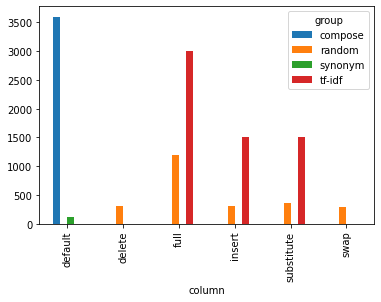

In [25]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

columns = ['insert', 'substitute', 'swap', 'delete', 'full', 'default']
data_to_plot = []
for augmenter_name in augmenter_names:
    for column in columns:
        value = 0
        full_name = augmenter_name + '-' + column
        if full_name in time_complexity: # better with defaultdict
            value = time_complexity[full_name]
        data_to_plot.append([augmenter_name, column, value])

df = pd.DataFrame(data=data_to_plot, columns=['group', 'column', 'val'])
df.pivot("column", "group", "val").plot(kind='bar')
plt.show()